# Analysis: How does Discover change a customer's purchasing behaviour?

#### Context: 
Previously, visitors of PCSG website may feel overwhelmed/at loss by the sheer amount of products listed. Having a product recommendation system aims to reduce the friction to navigation/purchase, thereby increasing sales.
    
### Methodology
1. Import and format Discover and Shopify sales data
2. Combine the details of each Discover taker's **earliest** attempt into Shopify data
3. Identify NEW customers and match their earliest purchase with their earliest Discover attempt
4. Perform calculations, such as:
    1. Percentage of transactions that actually contain at least one of the recommended SKUs
    2. Average/median/min/max time taken to purchase after attempting Discover
    3. etc

### Note: 
1. This excludes: 
    1. All the customers who used Discover but DID NOT make a purchase.
    2. New Customers who purchased **without trying Discover** (either because they didn't bother, or didn't know of its existence)
    3. All customers who made purchases before Discover was launched
2. We do not have a "control group", i.e.: the time taken for pre-Discover new customers to make a purchase after browsing the website
3. We could potentially investigate the behaviour of those who made their first purchase WITHOUT trying out Discover (i.e. point 2), but subsequently tried Discover)


**note to self: since this is a "partial" dataset, I will need to rerun this experiment with the full dataset**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 100)

discover_data = pd.read_csv("discover_user_input_results.csv")
discover_data = discover_data[discover_data['email'] != 'jeremy@paulaschoice.sg']

# Obtain only the earliest attempt of each Discover taker
discover_first = discover_data.drop_duplicates(subset = ['email'], keep='first').copy()
discover_first['timestamp_proper'] = pd.to_datetime(discover_first['timestamp'].map(lambda x: x.replace('th', "")))
discover_first.drop('timestamp', axis=1,inplace=True)
discover_first.head()
# discover_first.to_csv('discover_first.csv')


,Unnamed: 0,email,sensitivity,skinType,concern_0,concern_1,concern_2,concern_3,concern_4,concern_5,concern_6,concern_7,concern_8,concern_9,concern_10,concern_11,concern_12,concern_13,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,timestamp_proper
2,937,ck1411@singnet.com.sg,False,Combination,Enlarged Pores,Sun Damage,Wrinkles,Dehydration,Loss of Firmness,Dullness,Combination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7830,7780,7820,7740,7870,7760,7690,2760,7900,7960,2017-09-09 14:38:56
4,939,starlites18@gmail.com,False,Combination,Enlarged Pores,Clogged Pores,Acne,Sun Damage,Uneven Texture,Redness,Combination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6002,1350,2010,7740,7870,6130,7690,2750,5700,7730,2017-09-09 14:59:07
5,940,angelleexinyin@hotmail.com,True,Combination,Acne,Clogged Pores,Uneven Texture,Enlarged Pores,PIH,Dehydration,Sensitivity,Combination,NaN,NaN,NaN,NaN,NaN,NaN,7830,1350,6200,7740,7870,6130,7690,2750,5700,7730,2017-09-09 15:17:38
6,941,leong_lorna@hotmail.com,True,Oily,Clogged Pores,Acne,PIH,Enlarged Pores,Uneven Texture,Sensitivity,Oily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6002,1350,6200,7740,7870,6130,7690,2750,5700,7730,2017-09-09 15:38:11
7,942,xiaofangtm89@gmail.com,False,Combination,Enlarged Pores,Clogged Pores,Acne,Uneven Texture,Redness,Dehydration,Dullness,PIH,Loss of Firmness,Combination,NaN,NaN,NaN,NaN,7830,7670,2010,7740,7870,6130,7690,2760,5700,7730,2017-09-09 15:39:21


In [7]:
''' 
Sales Data
1. Import sales_data (dated 2018-02-07) and perform basic formatting 
2. Match the emails available from Discover dataset to sales data, and create a new column called "discover_first_date" to indicate when did the customer first use Discover
    Note: doing this excludes all the customers who used Discover but DID NOT make a purchase.
3. Create a second new column to indicate whether a transaction is made BEFORE/AFTER the customer has tried Discover.
    Note: customers that have not tried Discover *at all* but made a purchase will also show "Not Yet"
    Perhaps those who have not tried Discover at all should have a third status ("Not at all")?
4. Create a third column to indicate the time taken between the customer's first attempt of Discover and their current transaction.
'''

# Import Shopify sales_data (dated 2018-02-07) and perform basic formatting 
sales_data = pd.read_csv("shopify_orders_export_20180207.csv", 
                         low_memory=False, 
                         parse_dates=['Paid at', 'Fulfilled at', 'Created at'])

sales_data_clean = sales_data.drop(sales_data.columns.to_series()[-11:-1], axis=1)
sales_data_clean.dropna(subset=['Email'], axis=0, inplace=True)


# Match the emails available from Discover dataset to sales data, 
# and create a new column called `"discover_first_date"` to indicate 
# if and when customer first used Discover
sales_data_clean['discover_first_date'] = sales_data_clean['Email'].map(discover_first.set_index('email')['timestamp_proper'])

# Calculate `'used_discover_already'` : whether a transaction is made 
# BEFORE/AFTER the customer has tried Discover.
sales_data_clean['used_discover_already'] = (sales_data_clean['Created at']> sales_data_clean['discover_first_date']).map({True: "Used Discover", False: "Not yet"})

# Just to calculate the lead time to sales after trying Discover
sales_data_clean['discover_sales_lead_time'] = sales_data_clean['Created at'] - sales_data_clean['discover_first_date']

sales_data_clean.head(10)

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Outstanding Balance,Employee,Location,Device ID,Id,Tags,Risk Level,Source,Lineitem discount,Phone,discover_first_date,used_discover_already,discover_sales_lead_time
0,191569914712,gilly.glanville@me.com,paid,2018-02-08 03:59:00,fulfilled,2018-02-08 03:59:01,yes,SGD,290.0,0.0,0.0,290.0,5OFFe53b8c2fb9df,5.0,NaN,2018-02-08 03:59:00,1,Resist Skin Restoring Moisturizer SPF 50 - 60ml,48.0,0.0,7970,True,False,fulfilled,Gilly Glanville,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,External Credit,c563530104851.1,0.0,Paula's Choice,0.0,Jeremy Tan,Beauty Collective,9.0,1.811065e+11,NaN,Low,pos,0.0,NaN,NaT,Not yet,NaT
1,191569914712,gilly.glanville@me.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-08 03:59:00,1,Resist Optimal Results Hydrating Cleanser - 19...,36.0,0.0,7600,True,False,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paula's Choice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaT,Not yet,NaT
2,191569914712,gilly.glanville@me.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-08 03:59:00,1,Resist Advanced Smoothing Treatment 10% AHA (G...,55.0,0.0,7651,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paula's Choice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaT,Not yet,NaT
3,191569914712,gilly.glanville@me.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-08 03:59:00,1,Resist C15 Super Booster - 20 ml,68.0,0.0,7770,True,False,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paula's Choice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaT,Not yet,NaT
4,191569914712,gilly.glanville@me.com,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-08 03:59:00,1,Clinical Ceramide-Enriched Firming Moisturizer,88.0,0.0,2120,True,False,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paula's Choice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaT,Not yet,NaT
5,191569914711,stephaniedata@yahoo.com,paid,2018-02-08 03:39:25,unfulfilled,NaT,no,SGD,38.0,5.5,0.0,43.5,5OFF5359ca0ded5b,5.0,2 Working-Day Delivery,2018-02-08 03:39:25,1,Clear Acne Extra Strength Exfoliating Treatmen...,43.0,NaN,6210,True,False,pending,Stephanie Ng,"6 Napier Road 07-05, Gleneagles Medical Centre...",6 Napier Road 07-05,Gleneagles Medical Centre 07-05,The Dermatology Practice at Gleneagles,Singapore,'258499,NaN,SG,9001 9072,Stephanie Ng,"6 Napier Road 07-05, Gleneagles Medical Centre...",6 Napier Road 07-05,Gleneagles Medical Centre 07-05,The Dermatology Practice at Gleneagles,Singapore,'258499,NaN,SG,9001 9072,NaN,NaN,NaN,Stripe,c531555713043.1,0.0,Paula's Choice,0.0,NaN,NaN,NaN,1.810939e+11,NaN,Low,web,0.0,6.590019e+09,NaT,Not yet,NaT
6,191569914710,hsmeaton@hotmail.com,paid,2018-02-08 00:42:57,unfulfilled,NaT,yes,SGD,48.0,9.0,0.0,57.0,NaN,0.0,Free Shipping above S$99 (ex.Taxes & Fees),2018-02-08 00:42:56,1,Calm Sensitive Daytime Moisturizer SPF 30 (Nor...,48.0,NaN,9130,True,False,pending,Heather Smeaton,"C3-4-1 Pantai Hillpark Phase 1, Jln Pantai Dalam",C3-4-1 Pantai Hillpark Phase 1,Jln Pantai Da

In [10]:


'''
comparison_table = sales_data_clean[['Email', 'Created at', 'discover_first_date', 'used_discover_already']]
comparison_table['discover_sales_lead_time'] = comparison_table['Created at'] - comparison_table['discover_first_date']
'''

# Filter for transactions that were made within a day of attempting Discover
same_day_purchase = sales_data_clean[(sales_data_clean['discover_sales_lead_time'] <= "1 days") & (sales_data_clean['discover_sales_lead_time'] > "0 days")]
same_day_purchases_count = len(same_day_purchase['Email'].unique())

# Perform a count and percentage of customer analysis 
post_discover_all_sales_customer_count = len(post_discover_sales['Email'].unique())
percentage_same_day_purchase = same_day_purchases_count/post_discover_all_sales_customer_count
print("same_day_purchases_count:", same_day_purchases_count)
print("post_discover_all_sales_customer_count:", post_discover_all_sales_customer_count)
print("percentage_same_day_purchase: {:.2f}%".format(100*percentage_same_day_purchase))

# same_day_purchase.to_excel("same_day_purchase.xlsx")



same_day_purchases_count: 335
post_discover_all_sales_customer_count: 2847
percentage_same_day_purchase: 11.77%


In [20]:
# Create two dataframes that include transactions before and on/after Discover launch (2017-09-09)
pre_discover_sales = sales_data_clean[sales_data_clean['Created at']< "2017-09-09"]
post_discover_sales = sales_data_clean[sales_data_clean['Created at']>= "2017-09-09"]

# Create a new dataframe from post_discover_sales
# that include only new users who took discover

only_users_from_post_discover_sales = post_discover_sales[post_discover_sales['Email'].isin(discover_first['email'].unique())]
only_users_from_post_discover_sales

# sales_data_clean[sales_data_clean['Email'] == 'jovi.kau@gmail.com']

# Create a new dataframe containing UNIQUE emails from post_discover_sales
post_launch_emails = pd.DataFrame(post_discover_sales['Email'].unique(), 
                                  columns=["Post Launch Emails"])

# Test if these emails are also found in pre_discover_sales email list
post_launch_emails['Exist before launch?'] = post_launch_emails.isin(pre_discover_sales['Email'].unique())

# Merge (aka Join) Discover Data with emails in post_launch_emails
# and create columns to indicate whether and when did the email tried discover
post_launch_emails = post_launch_emails.merge(right=discover_first[['email', 'timestamp_proper']], 
                                              left_on='Post Launch Emails', 
                                              right_on='email')

# Delete the extra email column created after joining
post_launch_emails = post_launch_emails.drop('email', axis=1)

# Rename the column into something more elucidatory
post_launch_emails = post_launch_emails.rename(index=str, columns={"timestamp_proper": "First Tried Discover"})

# get first transaction date of each of the "new" customers
# Remember that sales_data is reverse-chronologically indexed
post_launch_first_purchase = post_discover_sales[['Email', 'Created at']].drop_duplicates(subset='Email', keep='last')
print("Number of rows:", len(post_launch_first_purchase))
post_launch_first_purchase

post_launch_emails = post_launch_emails.merge(post_launch_first_purchase, 
                                              left_on="Post Launch Emails", 
                                              right_on="Email")
post_launch_emails = post_launch_emails.drop('Email', axis=1).rename(index=str, 
                                                                     columns={"Created at": "First Transaction Post Launch"})

post_launch_emails['Time To Buy'] = post_launch_emails['First Transaction Post Launch'] - post_launch_emails['First Tried Discover']

# Filter for purchases made in 1 day (if necessary)
# post_launch_emails = post_launch_emails[(post_launch_emails['Time To Buy']> "0 days") & (post_launch_emails['Exist before launch?'] == False)]

# Lead time to purchase for new customers after taking Discover
print(post_launch_emails[(post_launch_emails['Time To Buy'] > '0 days') & 
                         (post_launch_emails['Exist before launch?'] == False)]['Time To Buy'].describe())
print('Top 85% of time to buy:', post_launch_emails[(post_launch_emails['Time To Buy'] > '0 days') & 
                         (post_launch_emails['Exist before launch?'] == False)]['Time To Buy'].quantile(0.85))

post_launch_emails.head(5)

Number of rows: 2847
count                        346
mean     10 days 03:05:21.540462
std      21 days 16:32:44.176929
min              0 days 00:01:22
25%       0 days 00:19:19.500000
50%       0 days 09:24:47.500000
75%       9 days 00:29:25.250000
max            139 days 05:01:07
Name: Time To Buy, dtype: object
Top 85% of time to buy: 22 days 01:29:42.500000


,Post Launch Emails,Exist before launch?,First Tried Discover,First Transaction Post Launch,Time To Buy
0,jglyj82@gmail.com,False,2018-02-07 12:54:54,2018-02-07 13:02:33,0 days 00:07:39
1,zarr.gyii@gmail.com,True,2017-09-26 03:45:14,2017-09-26 05:10:37,0 days 01:25:23
2,ycobonpue@gmail.com,True,2017-10-31 06:06:57,2017-09-19 06:46:41,-42 days +00:39:44
3,karenkhor27@gmail.com,True,2017-09-13 02:03:15,2017-09-18 07:12:43,5 days 05:09:28
4,boazruth76@yahoo.com,False,2018-01-24 09:57:32,2018-01-11 04:18:16,-14 days +18:20:44


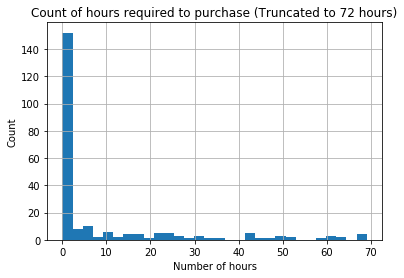

In [24]:
post_launch_emails[(post_launch_emails['Time To Buy'] > '0 days') & 
                   (post_launch_emails['Time To Buy'] < '3 days') & 
                         (post_launch_emails['Exist before launch?'] == False)]['Time To Buy'].apply(lambda x: (x/pd.Timedelta(hours=1))).set_index('Post Launch Emails').cumsum()

plt.title('Count of hours required to purchase (Truncated to 72 hours)')
plt.xlabel('Number of hours')
plt.ylabel('Count');

In [40]:
# Average Order Value of _New_ Customers who made their first purchase after taking Discover

new_discover_sale_transaction = post_discover_sales[post_discover_sales['Email'].isin(new_customers_test['Post Launch Emails'].unique())]
# new_discover_sale_transaction.groupby(by=['Email', 'Created at'])['Total'].sum()
new_discover_sale_transaction['Total'].mean()


NameError: name 'new_customers_test' is not defined

### 50% of our new customers made a purchase within 10 hours after trying out Discover!
From the calculation above, we know that: 
1. there are 2847 first-time purchases since Discover was launched.
2. on average, it takes about **10 days** for a customer to make a purchase after using Discover
3. 50% of transactions since Discover was launched occured within **5 hours** of trying out Discover

In [23]:
# Obtain a list of transactions for NEW customers who made their first purchase WITHOUT trying Discover

count_with_discover = len(post_launch_emails[(post_launch_emails['Time To Buy'] >= '0 days') & 
                   (post_launch_emails['Exist before launch?'] == False)]['Post Launch Emails'].unique())
count_without_discover = len(post_launch_emails[(post_launch_emails['Time To Buy'] < '0 days') & 
                   (post_launch_emails['Exist before launch?'] == False)]['Post Launch Emails'].unique())

print('Unique count of new customers who purchased after trying Discover: {}'.format(count_with_discover))
print('Unique count of new customers who purchased without trying Discover: {}'.format(count_without_discover))
print('{:.1f}% of new customers made a purchase after trying out Discover'.format(count_with_discover/(count_with_discover + count_without_discover) * 100))

Unique count of new customers who purchased after trying Discover: 346
Unique count of new customers who purchased without trying Discover: 52
86.9% of new customers made a purchase after trying out Discover


In [39]:
count_with_discover = len(post_launch_emails[(post_launch_emails['Time To Buy'] >= '0 days') & 
                   (post_launch_emails['Exist before launch?'] == True)]['Post Launch Emails'].unique())
count_without_discover = len(post_launch_emails[(post_launch_emails['Time To Buy'] < '0 days') & 
                   (post_launch_emails['Exist before launch?'] == True)]['Post Launch Emails'].unique())

print('Distribution of time to buy for existing customers: \n{}'.format(post_launch_emails[(post_launch_emails['Time To Buy'] >= '0 days') & 
                         (post_launch_emails['Exist before launch?'] == True)]['Time To Buy'].describe()))
print('Top 85% of time to buy:', post_launch_emails[(post_launch_emails['Time To Buy'] > '0 days') & 
                         (post_launch_emails['Exist before launch?'] == True)]['Time To Buy'].quantile(0.85))


print('Unique count of existing customers who purchased after trying Discover: {}'.format(count_with_discover))
print('Unique count of existing customers who purchased without trying Discover: {}'.format(count_without_discover))
print('{:.1f}% of existing customers who made a purchase after trying out Discover'.format(count_with_discover/(count_with_discover + count_without_discover) * 100))

Distribution of time to buy for existing customers: 
count                        273
mean     17 days 14:03:59.223443
std      27 days 07:27:59.561303
min              0 days 00:00:03
25%              0 days 00:47:03
50%              3 days 10:19:55
75%             23 days 23:01:24
max            132 days 05:56:15
Name: Time To Buy, dtype: object
Top 85% of time to buy: 42 days 16:45:23.799999
Unique count of existing customers who purchased after trying Discover: 273
Unique count of existing customers who purchased without trying Discover: 57
82.7% of existing customers who made a purchase after trying out Discover


#### Obtain a list of unique emails of NEW customers who made their first purchase *without* taking Discover

In [10]:

# Obtain a list of new customers who had made their first purchase post-launch without using Discover
new_cust_without_discover = post_launch_emails[(post_launch_emails['Time To Buy'] < pd.Timedelta('00:00:00')) & 
                                               (post_launch_emails['Exist before launch?'] == False)] 
                                                #['Post Launch Emails'].unique()

post_discover_sales[~post_discover_sales['Email'].isin(new_cust_without_discover['Post Launch Emails'].unique())]

# post_launch_emails was already defined earlier, and have not been altered in any way
first_sales_without_discover = post_discover_sales[~post_launch_emails.isin(pre_discover_sales['Email'].unique())]
first_sales_without_discover = first_sales_without_discover.dropna()
first_sales_without_discover

ValueError: Boolean array expected for the condition, not float64

In [ ]:
type(new_cust_without_discover['Time To Buy'][0])

In [ ]:
new_cust_without_discover = post_launch_emails[post_launch_emails['Time To Buy'] < pd.Timedelta('00:00:00')]
new_cust_without_discover

92.17494824016563

## Average Order Value of _New_ Customers who made their first purchase _without_ taking Discover

In [23]:
new_non_discover_sale_transaction = post_discover_sales[~post_discover_sales['Email'].isin(new_customers_test['Post Launch Emails'].unique())]
new_non_discover_sale_transaction['Total'].mean()

105.15647869674186

# Comparison

In [24]:
table_to_compare = pivot_discover_first
source_table_to_compare = sales_data_clean

In [25]:
multiindex_output = table_to_compare.set_index(keys=['email', 'SKU'])
multiindex_output

step_no
email                 SKU           
007lavender@gmail.com 6002  result_0
                      7670  result_1
                      6200  result_2
                      7740  result_3
                      7870  result_4
                      6130  result_5
                      7690  result_6
                      2750  result_7
                      5700  result_8
                      6240  result_9
1060138073@qq.com     1150  result_0
                      1350  result_1
                      2010  result_2
                      7740  result_3
                      7770  result_4
                      6130  result_5
                      3400  result_6
                      2750  result_7
                      5700  result_8
                      7730  result_9
1115006804@qq.com     1150  result_0
                      8510  result_1
                      6200  result_2
                      7740  result_3
                      7980  result_4
                      6130  result_5
                      3400  result_6
                      2750  result_7
                      5700  result_8
                      7730  result_9
...                              ...
zwying@gmail.com      6002  result_0
                      7670  result_1
                      6200  result_2
                      7740  result_3
                      7870  result_4
                      7800  result_5
                      7690  result_6
                      2750  result_7
                      5700  result_8
                      7730  result_9
zyan0981@gmail.com    1000  result_0
                      1250  result_1
                      2010  result_2
                      2130  result_3
                      7840  result_4
                      7970  result_5
                      7810  result_6
                      2800  result_7
                      5000  result_8
                      5200  result_9
NaN                   7830  result_0
                      1350  result_1
                      6200  result_2
                      7740  result_3
                      7860  result_4
                      6130  result_5
                      7690  result_6
                      2750  result_7
                      5700  result_8
                      7730  result_9

[24220 rows x 1 columns]

In [26]:
check_presence = multiindex_output.isin(source_table_to_compare[['Email', 'Lineitem sku']])
check_presence[check_presence['step_no'] == True]

,,step_no
email,SKU,


### Following code aims to examine the proportion of SKUs *actually* recommended to the customers
#### This helps to examine the trend of skin type (better to get from raw data for this)
"unpivot" ("melt" in Pandas term) in discover_first[result_SKUs].
### The objective is to allow for easier indexing to search for SKUs in sales_data_clean

In [10]:
# pivot_discover_first = discover_first.unstack(index='email', columns = ['result_0', 'result_1',
#       'result_2', 'result_3', 'result_4', 'result_5', 'result_6', 'result_7',
#       'result_8', 'result_9'])
pivot_discover_first = pd.melt(discover_first, 
                               id_vars='email',
                               value_vars=list(discover_first.columns[-11:-1]),
                               var_name='step_no',
                               value_name= 'SKU')

In [11]:
pivot_discover_first.sort_values(['email', 'step_no'], inplace=True)
# pivot_discover_first.to_excel("pivot_discover_first.xlsx")
# pivot_discover_first
discover_first.columns[-10:-1]
discover_first[discover_first['email'] == "yuleandra21@gmail.com"]
# same_day_purchase.groupby(by=['Email','Lineitem sku'])['Lineitem sku'].count()
#pivot_discover_first['Purchased?'] = pivot_discover_first['email'].map(same_day_purchase.set_index(['Email', 'Lineitem sku'])[])

'''Faced issues creating a frequency plot for SKUs under each email based on sales data
Abandoned using jupyter, tried on excel instead, also gave up subsequently
(Might need to use for loop with two filter criteria, but could not figure out how)'''